**Ensemble of InceptionResNetV2 and Xception, image resized by following the Central Tendency (to 375,500) trained for 12 Epochs using SGD Optimizer LR = 0.01 with a Validation Accuracy of 93.93%**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import seaborn as sns
%matplotlib inline

import tensorflow as tf

import sklearn

import os
import shutil

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
labels = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [3]:
data = pd.DataFrame(columns = ['filename','label'])

data['filename'] = labels['id'] + '.jpg'
data['label'] = labels['breed']

data.sample(10)

,filename,label
3543,5827b9cfa3d7962a2ee755524c915b24.jpg,malamute
6752,a93f2659ef71bcaf4859c8f8395f258e.jpg,afghan_hound
6169,9b596f56c3f3bc8058d35eb1944f60b5.jpg,rhodesian_ridgeback
4362,6cc02e5764a242a9d2b6469ef02eccd4.jpg,saint_bernard
4727,7684bc9005956e3fa3cbd7c8d4697e57.jpg,miniature_schnauzer
4771,77bbd2303fa579c249dfc4ce01832aac.jpg,english_foxhound
4286,6ad81076a0d7e9dd068147a105d4caab.jpg,dandie_dinmont
5141,81eab1d83dc63275941ee473de31e248.jpg,bernese_mountain_dog
4947,7c5ad29a20b9c3d082cda2d4d59ca492.jpg,kuvasz
9414,ec1f2e671f8b4531b203642664173ffd.jpg,kerry_blue_terrier


In [5]:
sub = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')

In [6]:
sub.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,...,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


In [7]:
test = pd.DataFrame()
test['filename'] = sub['id'] + '.jpg'
test.head()

,filename
0,000621fb3cbb32d8935728e48679680e.jpg
1,00102ee9d8eb90812350685311fe5890.jpg
2,0012a730dfa437f5f3613fb75efcd4ce.jpg
3,001510bc8570bbeee98c8d80c8a95ec1.jpg
4,001a5f3114548acdefa3d4da05474c2e.jpg


In [9]:
batch_size = 64
target_size = (375,500)
input_shape = (375,500,3)

**Defining Image Data Generator and Train Val Datasets**

In [11]:
idg = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.1)

In [12]:
train_idg = idg.flow_from_dataframe(dataframe = data, directory = "/kaggle/input/dog-breed-identification/train/",
                                    x_col="filename", y_col="label",
                                    target_size = target_size,
                                    batch_size = batch_size,
                                    subset="training")

Found 9200 validated image filenames belonging to 120 classes.


In [14]:
val_idg = idg.flow_from_dataframe(dataframe = data, directory = "/kaggle/input/dog-breed-identification/train/",
                                    x_col="filename", y_col="label",
                                    target_size = target_size,
                                    batch_size = batch_size,shuffle = False,
                                    subset="validation")

Found 1022 validated image filenames belonging to 120 classes.


In [15]:
test_idg = idg.flow_from_dataframe(dataframe = test, directory = "/kaggle/input/dog-breed-identification/test/",
                                    x_col = 'filename',
                                    class_mode = None, shuffle = False,
                                    target_size = target_size,
                                    batch_size = batch_size)

Found 10357 validated image filenames.


In [16]:
inception_no_top = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top = False, input_shape = input_shape)
xception_no_top = tf.keras.applications.xception.Xception(include_top = False, input_shape = input_shape)

83683744/83683744 [==============================] - 0s 0us/step


In [17]:
inception_no_top.input_shape, inception_no_top.output_shape

((None, 375, 500, 3), (None, 10, 14, 1536))

In [18]:
xception_no_top.input_shape, xception_no_top.output_shape

((None, 375, 500, 3), (None, 12, 16, 2048))

**Ensembling for feature extraction**

In [19]:
from keras.applications import inception_resnet_v2
from keras.utils.traceback_utils import include_frame

# 1. Input Layer
input = tf.keras.layers.Input(input_shape, name = "Input_Layer")

# 2. InceptionResNetV2
# 2.1 Preprocessing InceptionResNetV2 using Lambda layer
inception_pre_process = tf.keras.layers.Lambda(tf.keras.applications.inception_resnet_v2.preprocess_input,
                                               name = "Inception_PreProcess") (input)
# 2.2 Get IncpetionResNetV2 Model
inception_model = inception_no_top
inception_model.trainable = False

#2.2.1 Pass InceptionReseNetV2 Model through functional model by linking to preprocess layer
inception = inception_model (inception_pre_process)

# 2.3 Global Average Pooling
inception_avg = tf.keras.layers.GlobalAveragePooling2D(name="InceptionGAP") (inception)

# 3. Xception
# 3.1 Preprocessing Xception using Lambda layer
xception_pre_process = tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input,
                                               name = "Xception_PreProcess") (input)
# 3.2 Get Xception Model
xception_model = xception_no_top
xception_model.trainable = False

#3.2.1 Pass Xception Model through functional model by linking to preprocess layer
xception = xception_model (xception_pre_process)

# 3.3 Global Average Pooling
xception_avg = tf.keras.layers.GlobalAveragePooling2D(name="XceptionGAP") (xception)

# 4. Ensemble Features of InceptionResnetV2 and Xception
concat = tf.keras.layers.Concatenate(name = "Concat") ([inception_avg, xception_avg])

# 5. Connecting the Dense and Output Layers
dense1 = tf.keras.layers.Dense(512, activation = tf.keras.activations.relu, name = "Dense_1") (concat)
dense2 = tf.keras.layers.Dense(512, activation = tf.keras.activations.relu, name = "Dense_2") (dense1)
output = tf.keras.layers.Dense(120, activation="softmax", name="Output") (dense2)

In [20]:
# Assembling the Ensemble and Summarizing
final_model = tf.keras.models.Model(inputs= [input],outputs= [output])
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None, 375, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 Inception_PreProcess (Lambda)  (None, 375, 500, 3)  0           ['Input_Layer[0][0]']            
                                                                                                  
 Xception_PreProcess (Lambda)   (None, 375, 500, 3)  0           ['Input_Layer[0][0]']            
                                                                                                  
 inception_resnet_v2 (Functiona  (None, 10, 14, 1536  54336736   ['Inception_PreProcess[0][0]'

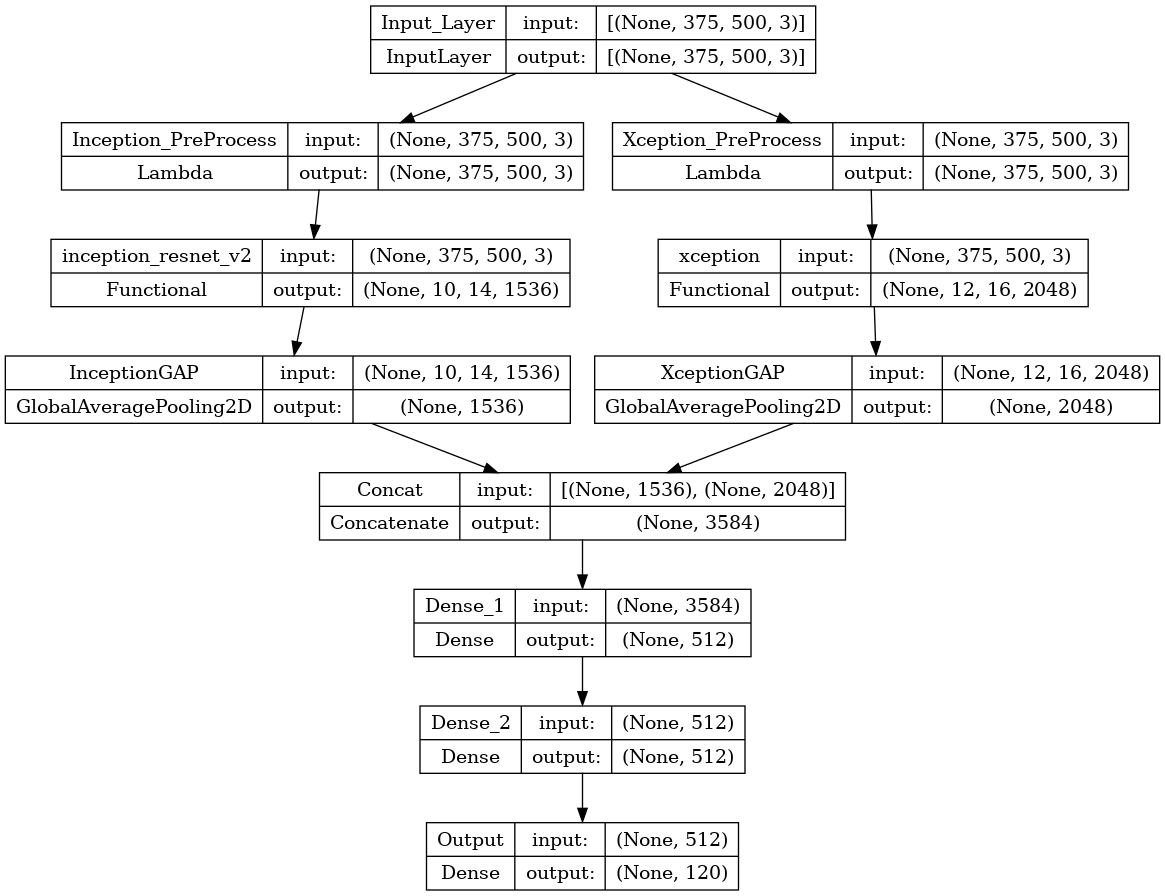

In [21]:
tf.keras.utils.plot_model(final_model, show_shapes = True, show_layer_names=True)

In [23]:
# Compiling the model
final_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
                    loss=tf.keras.losses.categorical_crossentropy,
                    metrics = ["acc"])

In [24]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                                 verbose=0, mode='min')

mcp_save = tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True,
                                              monitor='val_loss', mode='min')

reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                      patience=3, verbose=1, min_delta=1e-4, mode='min')

callbacks = [earlyStopping, mcp_save, reduce_lr_loss]

In [25]:
%%time
final_model.fit(train_idg, batch_size=batch_size, validation_data=val_idg, epochs=15, callbacks = callbacks)

Epoch 1/15
144/144 [==============================] - 234s 1s/step - loss: 4.7235 - acc: 0.0464 - val_loss: 4.6449 - val_acc: 0.1301 - lr: 0.0100
Epoch 2/15
144/144 [==============================] - 184s 1s/step - loss: 4.5441 - acc: 0.2514 - val_loss: 4.4368 - val_acc: 0.3953 - lr: 0.0100
Epoch 3/15
144/144 [==============================] - 186s 1s/step - loss: 4.2883 - acc: 0.5393 - val_loss: 4.1318 - val_acc: 0.6380 - lr: 0.0100
Epoch 4/15
144/144 [==============================] - 184s 1s/step - loss: 3.9194 - acc: 0.7060 - val_loss: 3.7048 - val_acc: 0.7446 - lr: 0.0100
Epoch 5/15
144/144 [==============================] - 184s 1s/step - loss: 3.4217 - acc: 0.7877 - val_loss: 3.1456 - val_acc: 0.7945 - lr: 0.0100
Epoch 6/15
144/144 [==============================] - 184s 1s/step - loss: 2.8008 - acc: 0.8353 - val_loss: 2.4836 - val_acc: 0.8483 - lr: 0.0100
Epoch 7/15
144/144 [==============================] - 184s 1s/step - loss: 2.1167 - acc: 0.8767 - val_loss: 1.8072 - val_acc

Text(0.5, 1.0, 'Accuracy of Model')

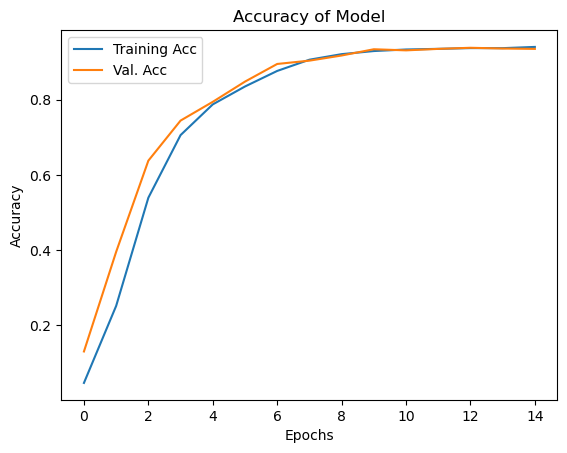

In [27]:
plt.plot(final_model.history.history["acc"], label = "Training Acc")
plt.plot(final_model.history.history["val_acc"], label = "Val. Acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy of Model")

Text(0.5, 1.0, 'Loss - Training vs Validation')

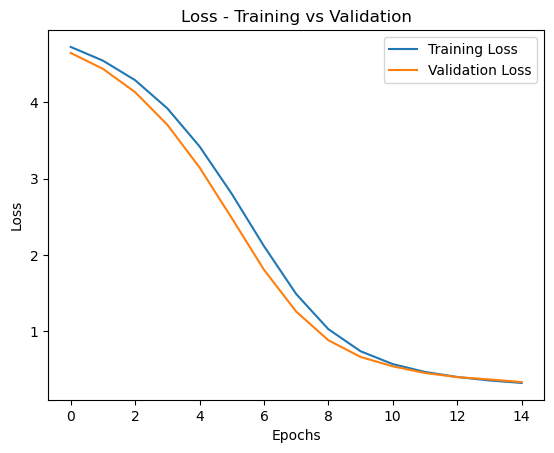

In [30]:
plt.plot(final_model.history.history["loss"], label = "Training Loss")
plt.plot(final_model.history.history["val_loss"], label = "Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss - Training vs Validation")

In [31]:
loss = final_model.history.history["loss"]
val_loss = final_model.history.history["val_loss"]
acc = final_model.history.history["acc"]
val_acc = final_model.history.history["val_acc"]

# Create the DataFrame
model_perf = pd.DataFrame({
    "Training_Loss": loss,
    "Validation_Loss": val_loss,
    "Training_Accuracy": acc,
    "Validation_Accuracy": val_acc
})

model_perf.insert(0, "Epoch", range(1, len(model_perf) + 1))

In [32]:
model_perf.to_csv('Ensemble_6.csv',index=False)

In [34]:
final_model.save("Dog_Breed_Identification_VGG16_Model.h5")
# Evaluate the model
score = final_model.evaluate(val_idg, verbose=0)
print('Validation Loss = ', score[0])
print('Validation Accuracy = ', score[1])

Validation Loss =  0.3370184898376465
Validation Accuracy =  0.9354207515716553


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
plt.style.use('ggplot')

%matplotlib inline

In [36]:
breed_mapping = dict(zip(val_idg.class_indices.values(), val_idg.class_indices.keys()))
breed_mapping

{0: 'affenpinscher',
 1: 'afghan_hound',
 2: 'african_hunting_dog',
 3: 'airedale',
 4: 'american_staffordshire_terrier',
 5: 'appenzeller',
 6: 'australian_terrier',
 7: 'basenji',
 8: 'basset',
 9: 'beagle',
 10: 'bedlington_terrier',
 11: 'bernese_mountain_dog',
 12: 'black-and-tan_coonhound',
 13: 'blenheim_spaniel',
 14: 'bloodhound',
 15: 'bluetick',
 16: 'border_collie',
 17: 'border_terrier',
 18: 'borzoi',
 19: 'boston_bull',
 20: 'bouvier_des_flandres',
 21: 'boxer',
 22: 'brabancon_griffon',
 23: 'briard',
 24: 'brittany_spaniel',
 25: 'bull_mastiff',
 26: 'cairn',
 27: 'cardigan',
 28: 'chesapeake_bay_retriever',
 29: 'chihuahua',
 30: 'chow',
 31: 'clumber',
 32: 'cocker_spaniel',
 33: 'collie',
 34: 'curly-coated_retriever',
 35: 'dandie_dinmont',
 36: 'dhole',
 37: 'dingo',
 38: 'doberman',
 39: 'english_foxhound',
 40: 'english_setter',
 41: 'english_springer',
 42: 'entlebucher',
 43: 'eskimo_dog',
 44: 'flat-coated_retriever',
 45: 'french_bulldog',
 46: 'german_sheph

In [37]:
# Predict probabilities for the validation set
pred_probs = final_model.predict(val_idg)

# Convert probabilities to predicted labels
pred_labels = np.argmax(pred_probs, axis=1)

# Generate classification report
class_names = train_idg.class_indices.keys()
report = sklearn.metrics.classification_report(val_idg.classes, pred_labels, target_names=class_names)

# Print the classification report
print(report)

16/16 [==============================] - 22s 1s/step
                                precision    recall  f1-score   support

                 affenpinscher       0.91      1.00      0.95        10
                  afghan_hound       1.00      1.00      1.00        13
           african_hunting_dog       1.00      1.00      1.00        11
                      airedale       0.83      1.00      0.91        10
american_staffordshire_terrier       0.78      1.00      0.88         7
                   appenzeller       1.00      0.75      0.86         8
            australian_terrier       1.00      0.90      0.95        10
                       basenji       1.00      0.93      0.96        14
                        basset       1.00      1.00      1.00        12
                        beagle       0.80      1.00      0.89         8
            bedlington_terrier       1.00      1.00      1.00        11
          bernese_mountain_dog       0.93      1.00      0.96        13
       bla

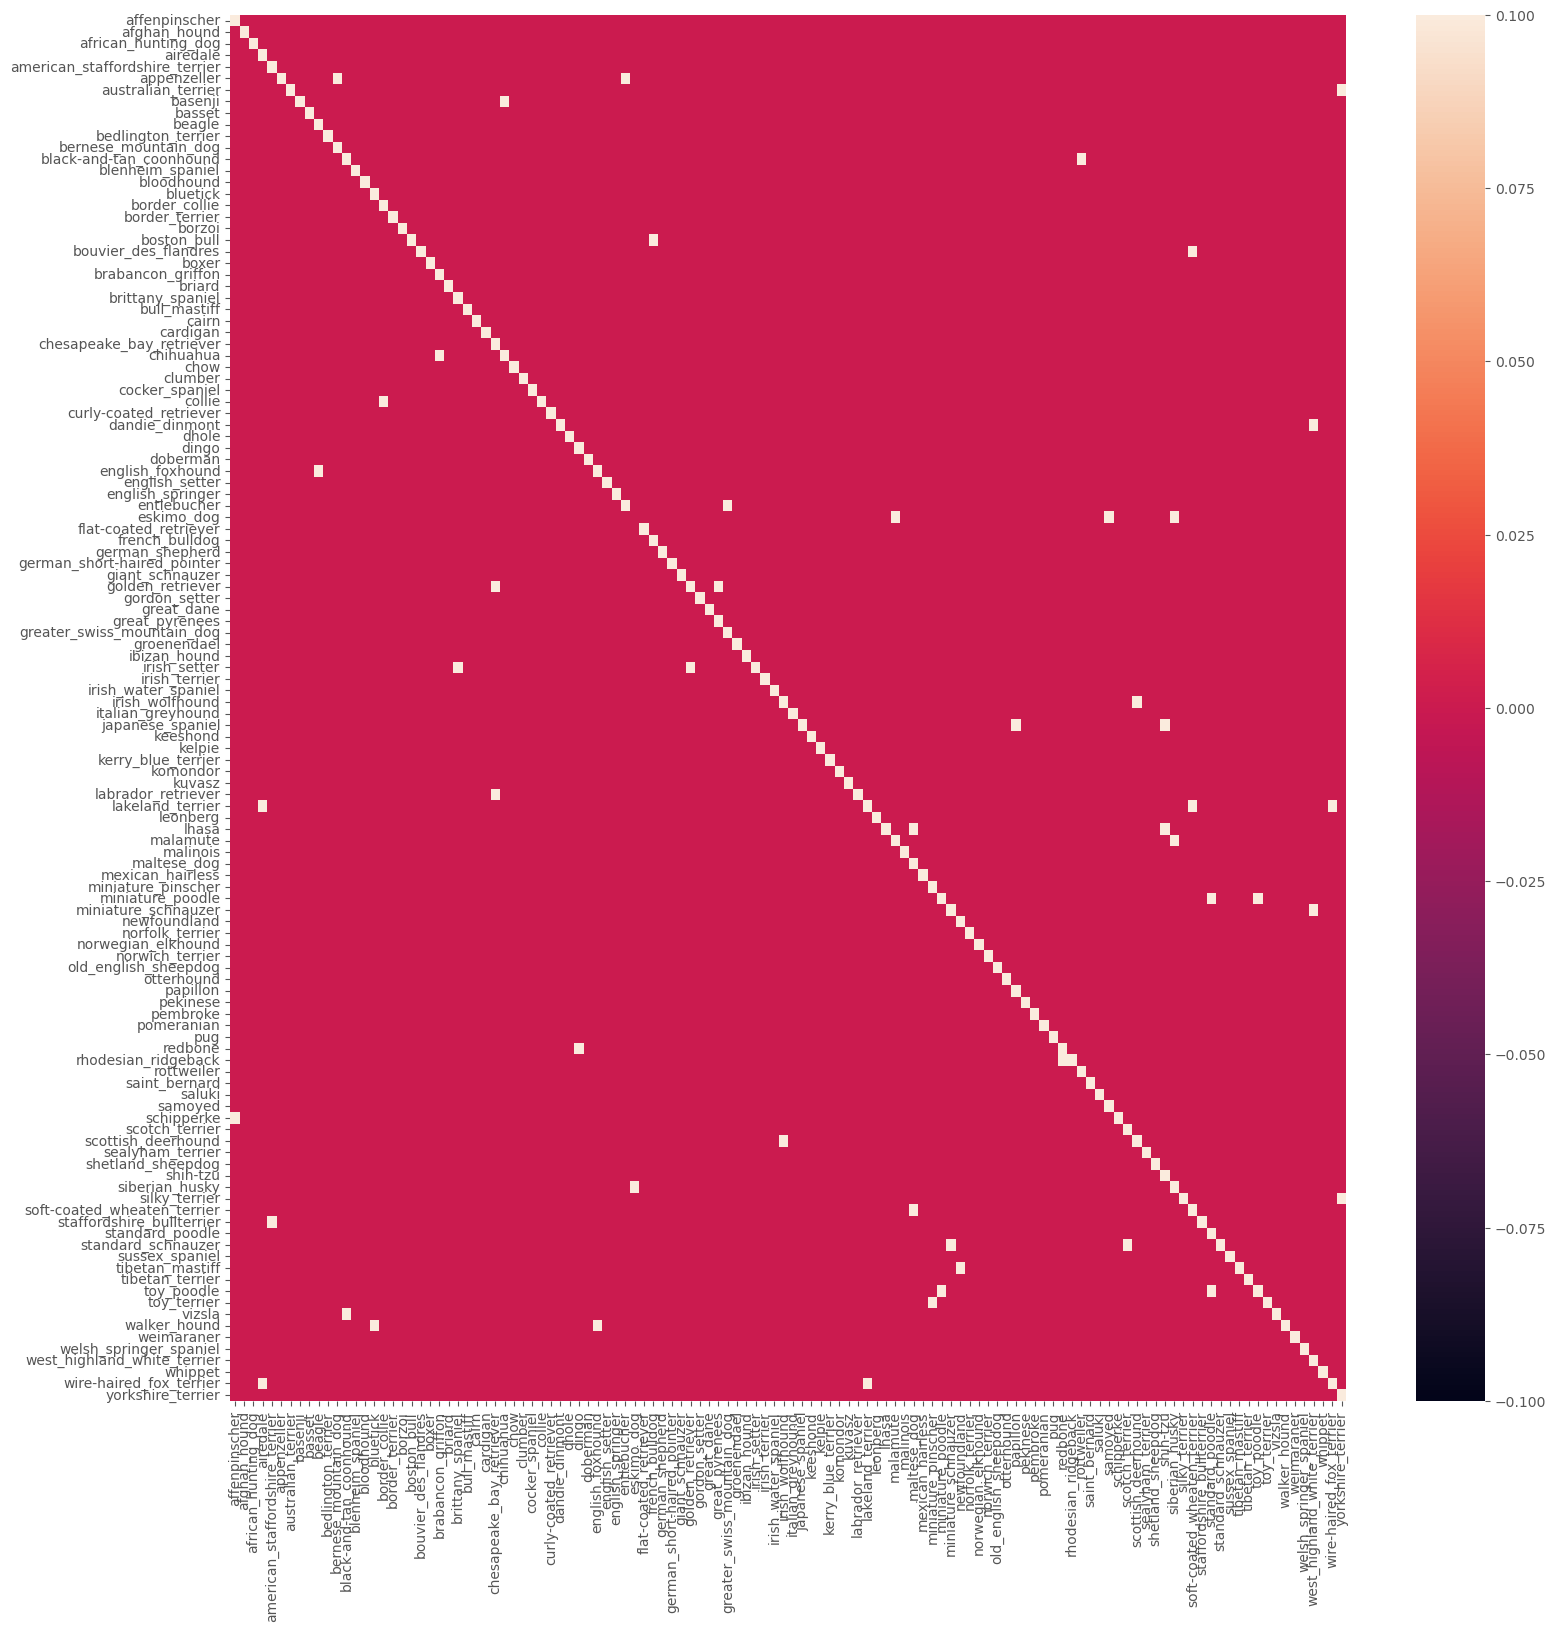

In [39]:
df = pd.DataFrame({'actual': val_idg.classes, 'pred': pred_labels})
# Get the unique breed labels
breeds = np.unique(df['actual'].values)
# Map the breed labels to their corresponding mapped values using breed_mapping dictionary
mapped_breeds = [breed_mapping[breed] for breed in breeds]
cm = confusion_matrix(df['actual'], df['pred'], labels=breeds)
fig, ax = plt.subplots(figsize=(18, 18))
_ = sns.heatmap(cm, ax=ax, yticklabels=mapped_breeds, xticklabels=mapped_breeds, robust=True)

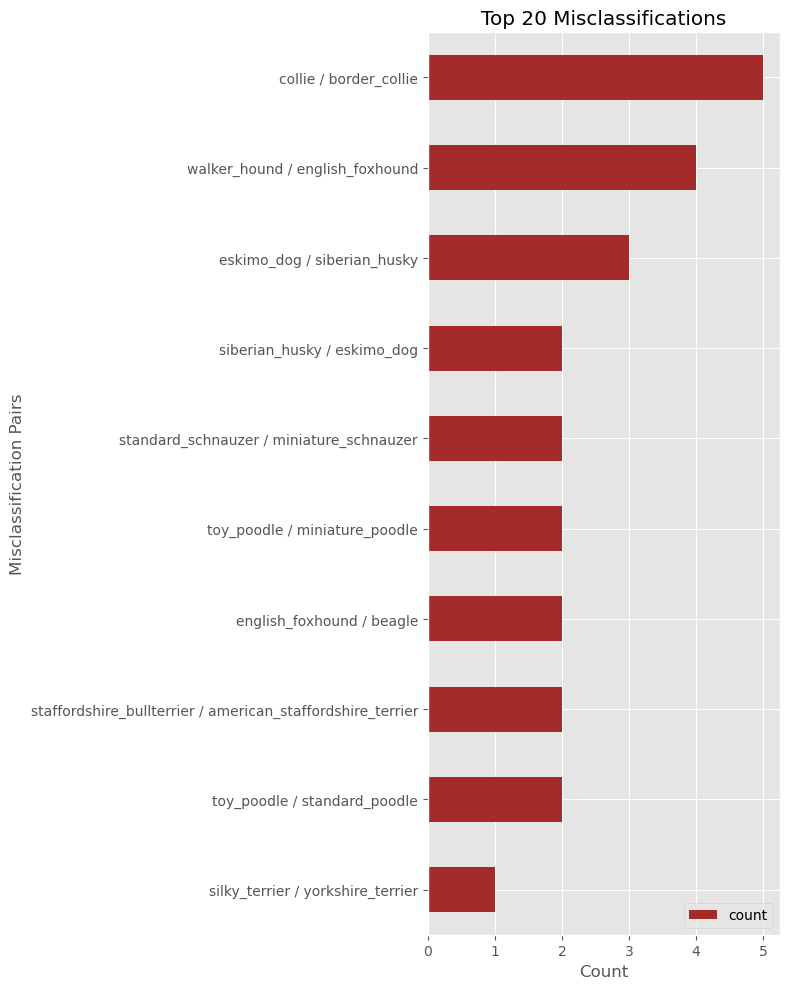

In [42]:
df = pd.DataFrame({'actual': val_idg.classes, 'pred': pred_labels})
# Replace the integer values with breed names using the breed_mapping dictionary
df['actual'] = df['actual'].map(breed_mapping)
df['pred'] = df['pred'].map(breed_mapping)
df['count'] = 1
misclass_df = df[df['actual'] != df['pred']].groupby(['actual', 'pred']).sum().sort_values(['count'], ascending=False).reset_index()
misclass_df['pair'] = misclass_df['actual'] + ' / ' + misclass_df['pred']
misclass_df = misclass_df[['pair', 'count']].take(range(10))

misclass_df.sort_values('count').plot.barh(figsize=(8, 10), y='count', x='pair', color='#A52A2A')

plt.xlabel('Count')
plt.ylabel('Misclassification Pairs')
plt.title('Top 20 Misclassifications')

plt.tight_layout()
plt.show()

In [44]:
targets = [col for col in sub.columns if col!='id']
len(targets)

120

In [45]:
predict = final_model.predict(test_idg, steps = len(test_idg.filenames))

10357/10357 [==============================] - 194s 18ms/step


In [51]:
sub[targets] = predict

In [53]:
sub.sample(10)

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
6780,a6f152a6be327ab48724fc58765c51d2,0.004252,0.004119,0.003294,0.013285,0.000538,0.000555,0.000377,0.000739,0.000127,...,0.002851,0.000810,0.003245,0.000735,0.004930,0.000570,0.000635,0.004955,0.007905,0.001194
5195,7ee3d9d8e1c78c11fe8da52b3ad70453,0.000445,0.000105,0.000486,0.000209,0.000073,0.002651,0.000042,0.000112,0.000548,...,0.000181,0.000288,0.000727,0.000749,0.000142,0.000463,0.000216,0.000285,0.000027,0.000169
5200,7f00d7b5531e1051f15de7219aeeb6db,0.000515,0.000073,0.000834,0.000934,0.002142,0.000458,0.000541,0.001800,0.000333,...,0.000445,0.000675,0.540662,0.003630,0.021364,0.000924,0.000149,0.000554,0.000901,0.000499
1269,1e2454e102a746bb78b5c38ae15710a0,0.000125,0.018260,0.000348,0.001115,0.000047,0.000027,0.000007,0.000015,0.000197,...,0.000068,0.000090,0.000254,0.000317,0.000110,0.000167,0.000150,0.003533,0.000477,0.000023
2602,3f09991195890109300ad911d87fd223,0.000314,0.001594,0.000233,0.001654,0.000015,0.000102,0.000041,0.000009,0.000582,...,0.000177,0.000025,0.000693,0.000143,0.001047,0.000515,0.000032,0.000260,0.000163,0.000111
10035,f863758735a6cc504d4a80477591eaf6,0.000077,0.000371,0.000105,0.003722,0.000129,0.000024,0.000226,0.000088,0.000046,...,0.000168,0.000672,0.000299,0.000512,0.000218,0.000275,0.000808,0.000380,0.850208,0.000224
5082,7be234f14e6207f497c00ae76a47dbec,0.000666,0.000148,0.001455,0.000028,0.002881,0.000598,0.000111,0.000342,0.001595,...,0.000305,0.000285,0.000164,0.001873,0.001670,0.000455,0.000128,0.001747,0.000083,0.000433
761,11b6d3d460aa9c03baa3cdd090307e23,0.000065,0.000007,0.000020,0.000017,0.000016,0.000034,0.000712,0.000048,0.000065,...,0.000013,0.000068,0.000025,0.000013,0.000050,0.000155,0.001007,0.000010,0.003932,0.000080
4175,65ee997f3113b2233ded1f67c82d965f,0.010974,0.000827,0.000279,0.000008,0.000022,0.000128,0.000106,0.000103,0.000430,...,0.000372,0.000220,0.000143,0.000205,0.000126,0.000019,0.001549,0.000632,0.000271,0.001557
7464,b85b25f17411e9d0c10a0ba785a31fe6,0.000249,0.000059,0.000428,0.000016,0.002693,0.002737,0.000814,0.939675,0.000057,...,0.000172,0.003522,0.000577,0.000220,0.000051,0.000127,0.000248,0.002697,0.000163,0.000424


In [54]:
sub.to_csv('Dog_Breed_InceptionResNetV2_Exception.csv',index = False)